# Opinion Dynamics control with OSAOC for larger networks

In [1]:
using PyPlot, LinearAlgebra, JuMP, Ipopt, Statistics, Permutations, SimpleValueGraphs, Graphs

In [2]:
include("karateclub_code.jl");
include("karateclub_plots.jl");

# Graph for Karate's Club

A real-world graph, [Zachary's Karate Club](https://www.jstor.org/stable/3629752), is used in this notebook as a larger example. It became a popular example of community structure in networks after its use by Michelle Girvan and Mark Newman in 2002 [(Here)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC122977/).

For opinion dynamics, this network is used as an example of real-world applications, for example: "[A social network group decision making framework with opinion dynamics considering opinion reliability](https://www.sciencedirect.com/science/article/pii/S0360835223005478)" and "[Dynamic behavior for social networks with state-dependent susceptibility and antagonistic interactions](https://www.sciencedirect.com/science/article/pii/S0005109821001722)". Both cases studies dynamics and consensus for this graph.

Our purpose is to control the agent's opinion using the methodology proposed in the work. The cell bellow loads the A matrix for the Karate Club's model. Note that we define two diferent dynamics: A_1 describes the case in which each agent ascribes equal weights to all neighbors and A_2 ascribes random weight to each neighbor.

In [3]:
#Zahary's Karate Club
G = smallgraph(:karate)
G_2 = AdjacencyMatrix(G);
n = 34;
W = zeros(n,n)
for i in 1:n
    for j in 1:n
        if G_2[i,j] == true
            W[i,j] = 1
        else
            W[i,j] = 0
        end
    end
end
D = W*ones(n,1);
A_1 = zeros(n,n)
for i in 1:n
   A_1[i,:] = W[i,:]./D[i] 
end

for i in 1:n
    for j in 1:n
        if G_2[i,j] == true
            W[i,j] = rand()
        else
            W[i,j] = 0
        end
    end
end
A_2 = rs_ize(W);

# Control

In cell bellow, we present the DeGroot model with Jacobi procedure. As the graph has 34 nodes, it is difficult to analyze the results in a competition (although it is possible to obtain control and results), so we show the case of consensus (a cooperative game) for the graph.

Note that, it is possible to use FJ and HK models for this graph: 

- "COD_OSA_J_targets_FJ(x_init,targets,γ,T,A_1,B,Θ,N_a,N_p,proj_flag)", for FJ model.
- "COD_OSA_J_targets_HK(x_init,targets,γ,T,A_1,B,u_min,u_max,F,W,flag_proj)", for HK model.

In [18]:
#Agents initial conditions
N_a =  size(A_1,1) #number of agents
x_init = rand(N_a,1)

#Players targets
N_p = 4
x1_hat = 0.4
x2_hat = 0.4
x3_hat = 0.4
x4_hat = 0.4

p1 = [x1_hat;zeros(N_a-1,1)]
p2 = [0;0;0;x2_hat;zeros(N_a-4,1) ]
p3 = [0;0;0;0;0;x3_hat; zeros(N_a-6,1)]
p4 = [0;0;0;0;0;0;0;0;x4_hat; zeros(N_a-9,1)]

targets = [p1 p2 p3 p4]

γ = [0.001; 0.001; 0.001;0.001];

#Control matrix
B = [p1./x1_hat p2./x2_hat p3./x3_hat p4./x4_hat ];

T = 60; #horizon
proj_flag = 0; #Projection flag = 1, all opinios are projected in a [-1;1] opinions
x_os, u_os = COD_OSA_J_DeGroot(x_init,targets,γ,T,A_1,B,N_a,N_p,proj_flag);

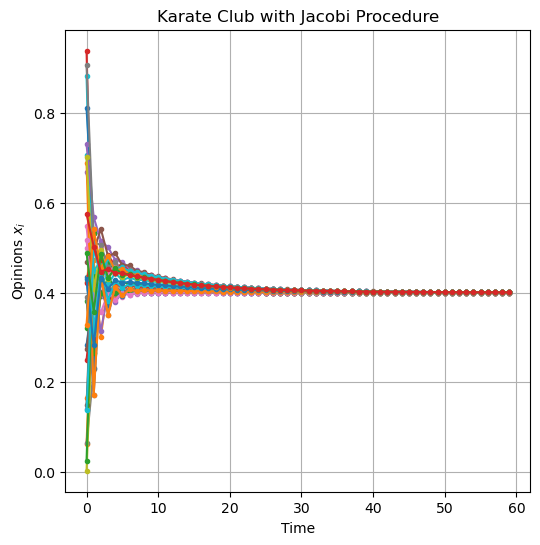

In [19]:
save = 0
plot_opinions(x_os,T);

# Using GS procedure

In [34]:
#Agents initial conditions
N_a =  size(A_1,1) #number of agents
x_init = rand(N_a,1)

#Players targets
N_p = 4
x1_hat = 0.4
x2_hat = 0.4
x3_hat = 0.4
x4_hat = 0.4

p1 = [x1_hat;zeros(N_a-1,1)]
p2 = [0;0;0;x2_hat;zeros(N_a-4,1) ]
p3 = [0;0;0;0;0;x3_hat; zeros(N_a-6,1)]
p4 = [0;0;0;0;0;0;0;0;x4_hat; zeros(N_a-9,1)]

targets = [p1 p2 p3 p4]

γ = [0.001; 0.001; 0.001;0.001];

#Control matrix
B = [p1./x1_hat p2./x2_hat p3./x3_hat p4./x4_hat ];

T = 60; #horizon

# For FJ model, choose the stubbornness matrix and eval A = (I-Θ)*A_1 (or A_2).
Θ = 0;
# For HK model, define the slope and the window.
F = 0;
W = 0;
proj_flag = 0;
perm_flag = 1;
model = 1;
#last digit is model: 1 - DeGroot; 2 - FJ; 3 - HK
x_os2, u_os2 = COD_OSA_GS(x_init,targets,γ,T,A_1,B,Θ,F,W,proj_flag,perm_flag, model);

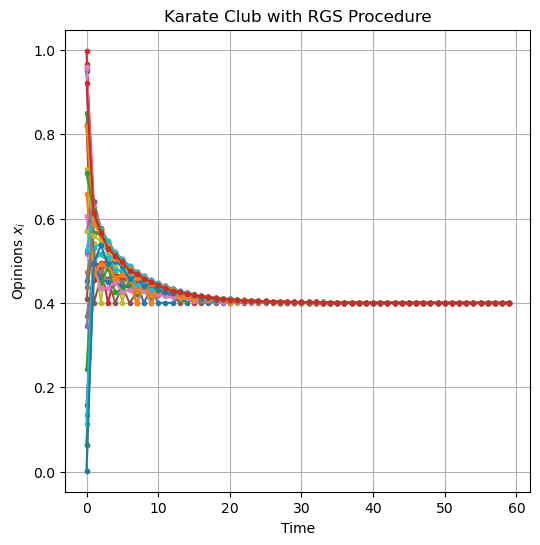

In [35]:
save = 0
plot_opinions2(x_os2,T);